In [1]:
import ciw
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from tqdm.notebook import tqdm
import pickle

In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))
import sd_component as sd
import des_component as des

### System Dynamics Component

In [3]:
initial_population = 100000
unwell_proportion = 0.1
unwell_splits = [0.1, 0.3, 0.6]
gatekeeping_threshold = 0.4
presenting_proportion = 0.002

max_time = 1000
time_points = 100000 + 1

In [4]:
def deterioration_rate_function(t):
    """
    Returns the deterioration rate as a function of time.
    """
    return 0.005

In [5]:
def incidence_rate_function(t):
    """
    Returns the incidence rate as a function of time.
    """
    return 0.0

In [6]:
A = sd.SD(
    initial_population=initial_population,
    unwell_proportion=unwell_proportion,
    unwell_splits=unwell_splits,
    gatekeeping_function=sd.proportional_gatekeeping(threshold=gatekeeping_threshold),
    presenting_proportion=presenting_proportion,
    deterioration_function=deterioration_rate_function,
    incidence_function=incidence_rate_function,
)
ts = np.linspace(0, max_time, time_points)
A.solve(t=ts)

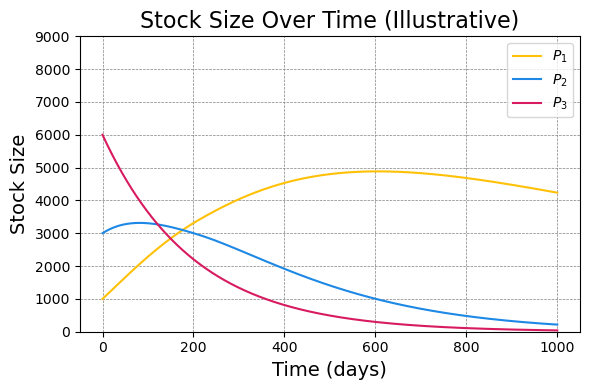

<Figure size 640x480 with 0 Axes>

In [7]:
sd.plot_stocks_over_time(
    A.P,
    t=ts,
    ylim=(0, 9000),
    title="Stock Size Over Time (Illustrative)",
    filename="plots/stock_size.pdf")

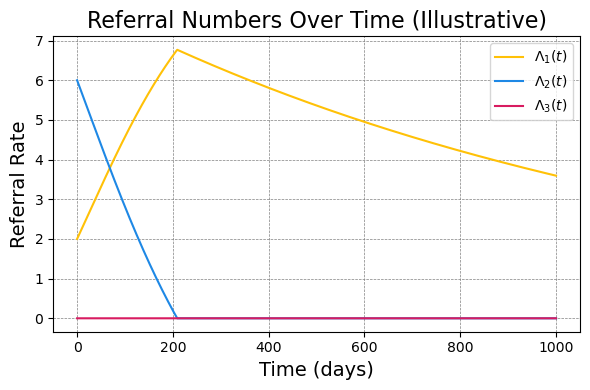

<Figure size 640x480 with 0 Axes>

In [8]:
sd.plot_referral_numbers_over_time(
    A.lambdas,
    t=ts,
    title="Referral Numbers Over Time (Illustrative)",
    filename="plots/referral_numbers.pdf")

### Loading the Subgroup PDFAs

In [9]:
alphabet = ["A", "B", "C", "D", "F", "G", "H", "I", "J"]

In [10]:
pdfa_one = np.load("../pdfas/example_high_pdfa.npy")
pdfa_one_alphabet = pickle.load(open("../pdfas/example_high_pdfa_alphabet.pkl", "rb"))

In [11]:
pdfa_two = np.load("../pdfas/example_medium_pdfa.npy")
pdfa_two_alphabet = pickle.load(open("../pdfas/example_medium_pdfa_alphabet.pkl", "rb"))

In [12]:
pdfa_three = np.load("../pdfas/example_low_pdfa.npy")
pdfa_three_alphabet = pickle.load(open("../pdfas/example_low_pdfa_alphabet.pkl", "rb"))

In [13]:
activity_dict, inv_dict = des.make_activity_dictionaries(alphabet=alphabet)

### Discrete-Event Simulation Component

In [13]:
LowCustomRouting = des.PDFARouting(
    pdfa_matrix=pdfa_one,
    alphabet=pdfa_one_alphabet,
    activity_dict=activity_dict,
)
MediumCustomRouting = des.PDFARouting(
    pdfa_matrix=pdfa_two,
    alphabet=pdfa_two_alphabet,
    activity_dict=activity_dict,
)
HighCustomRouting = des.PDFARouting(
    pdfa_matrix=pdfa_three,
    alphabet=pdfa_three_alphabet,
    activity_dict=activity_dict,
)

In [14]:
N = ciw.create_network(
    arrival_distributions={
        "Low": [
            ciw.dists.PoissonIntervals(
                rates=list(A.lambdas[2][:-1]),
                endpoints=list(ts[1:]),
                max_sample_date=1001,
            ),
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
        ],
        "Medium": [
            ciw.dists.PoissonIntervals(
                rates=list(A.lambdas[1][:-1]),
                endpoints=list(ts[1:]),
                max_sample_date=1001,
            ),
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
        ],
        "High": [
            ciw.dists.PoissonIntervals(
                rates=list(A.lambdas[0][:-1]),
                endpoints=list(ts[1:]),
                max_sample_date=1001,
            ),
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
            None,
        ],
    },
    service_distributions={
        "Low": [
            ciw.dists.Deterministic(value=0),
            ciw.dists.Deterministic(value=0.1),
            ciw.dists.Deterministic(value=0.1),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=1),
            ciw.dists.Deterministic(value=2 / 5),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=5 / 16),
            ciw.dists.Deterministic(value=5 / 16),
        ],
        "Medium": [
            ciw.dists.Deterministic(value=0),
            ciw.dists.Deterministic(value=0.1),
            ciw.dists.Deterministic(value=0.1),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=1),
            ciw.dists.Deterministic(value=2 / 5),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=5 / 16),
            ciw.dists.Deterministic(value=5 / 16),
        ],
        "High": [
            ciw.dists.Deterministic(value=0),
            ciw.dists.Deterministic(value=0.1),
            ciw.dists.Deterministic(value=0.1),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=1),
            ciw.dists.Deterministic(value=2 / 5),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=2 / 7),
            ciw.dists.Deterministic(value=5 / 16),
            ciw.dists.Deterministic(value=5 / 16),
        ],
    },
    number_of_servers=[float("inf"), 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    routing={
        "Low": ciw.routing.NetworkRouting(
            routers=[
                LowCustomRouting,
                LowCustomRouting,
                LowCustomRouting,
                LowCustomRouting,
                LowCustomRouting,
                LowCustomRouting,
                LowCustomRouting,
                LowCustomRouting,
                LowCustomRouting,
                LowCustomRouting,
                LowCustomRouting,
            ]
        ),
        "Medium": ciw.routing.NetworkRouting(
            routers=[
                MediumCustomRouting,
                MediumCustomRouting,
                MediumCustomRouting,
                MediumCustomRouting,
                MediumCustomRouting,
                MediumCustomRouting,
                MediumCustomRouting,
                MediumCustomRouting,
                MediumCustomRouting,
                MediumCustomRouting,
                MediumCustomRouting,
            ]
        ),
        "High": ciw.routing.NetworkRouting(
            routers=[
                HighCustomRouting,
                HighCustomRouting,
                HighCustomRouting,
                HighCustomRouting,
                HighCustomRouting,
                HighCustomRouting,
                HighCustomRouting,
                HighCustomRouting,
                HighCustomRouting,
                HighCustomRouting,
                HighCustomRouting,
            ]
        ),
    },
)

In [15]:
ciw.seed(0)
Q = ciw.Simulation(N)
Q.simulate_until_max_time(1000)
r = pd.DataFrame(Q.get_all_records())
r

,id_number,customer_class,original_customer_class,node,arrival_date,waiting_time,service_start_date,service_time,service_end_date,time_blocked,exit_date,destination,queue_size_at_arrival,queue_size_at_departure,server_id,record_type
0,4367,High,High,1,713.401437,0.000000,713.401437,0.000000,713.401437,0.0,713.401437,2,0,0,False,service
1,4367,High,High,2,713.401437,0.083126,713.484563,0.100000,713.584563,0.0,713.584563,4,1,0,1,service
2,4368,High,High,1,713.647261,0.000000,713.647261,0.000000,713.647261,0.0,713.647261,2,0,0,False,service
3,4368,High,High,2,713.647261,0.000000,713.647261,0.100000,713.747261,0.0,713.747261,4,0,0,1,service
4,4369,High,High,1,714.049912,0.000000,714.049912,0.000000,714.049912,0.0,714.049912,2,0,0,False,service
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19267,2411,High,High,9,997.127808,0.614286,997.742094,0.285714,998.027808,0.0,998.027808,9,3,3,1,service
19268,2411,High,High,9,998.027808,0.857143,998.884951,0.285714,999.170665,0.0,999.170665,-1,3,6,1,service
19269,4365,High,High,1,713.111403,0.000000,713.111403,0.000000,713.111403,0.0,713.111403,2,0,0,False,service
19270,4365,High,High,2,713.111403,0.094812,713.206215,0.100000,713.306215,0.0,713.306215,4,1,0,1,service
